# Learning to Play Blackjack
#### Galen Ballew, August 2018

*$\pi_0$ - Random Action*  
- At each time step, randomly sample from the action space
- Record the reward
- Run many episodes

*$\pi_1$ - Q-Table*
- Create a table
- Each State, $\mathcal{S_i}$, is a sample
- Each Action, $\mathcal{A_i}$, is a feature
- Using $\pi_0$ episodic results, compute the average cumulative reward for each state-action pair
 - What if the same state-action pair is used more than once in an episode?
   1. *Every-visit Monte Carlo Prediction* - Use the average
     - Biased. Has initial low Mean Squared Error.
   2. *First-visit MC Prediction* - Only use the cumulative reward from the first time the action was chosen
     - Unbiased. MSE drops below Every-visit with enough episodes.
 - **Note:** Q-Table will contain the *average* of First-visit predictions across all episodes
- This policy, $\pi^\prime$, is better than $\pi_0$, but not necessarily the optimal policy $\pi_*$
- The Q-table approximates the action-value function $\mathcal{q}\pi$ via $\max{\mathcal{S_i}}$

**The Policy Problem**
> Given a policy, how might the agent predict the value function for that policy? This applies to both the action-value function and the state-value function.

The Q-Table is a means to solve/estimate the Policy Problem.

## Blackjack
> Blackjack is a card game where the goal is to obtain cards that sum to as
near as possible to 21 without going over.  They're playing against a fixed
dealer.<br><br>
Face cards (Jack, Queen, King) have point value 10.
Aces can either count as 11 or 1, and it's called 'usable' at 11.
This game is placed with an infinite deck (or with replacement).
The game starts with each (player and dealer) having one face up and one
face down card.<br>
The player can request additional cards (hit=1) until they decide to stop
(stick=0) or exceed 21 (bust).<br><br>
After the player sticks, the dealer reveals their facedown card, and draws
until their sum is 17 or greater.  If the dealer goes bust the player wins.<br><br>
If neither player nor dealer busts, the outcome (win, lose, draw) is
decided by whose sum is closer to 21.  The reward for winning is +1,
drawing is 0, and losing is -1.<br><br>
The observation of a 3-tuple of: the players current sum,
the dealer's one showing card (1-10 where 1 is ace),
and whether or not the player holds a usable ace (0 or 1).<br><br>
This environment corresponds to the version of the blackjack problem
described in Example 5.1 in Reinforcement Learning: An Introduction
by Sutton and Barto (1998).
http://incompleteideas.net/sutton/book/the-book.html

In [1]:
import sys
import gym
import numpy as np
from collections import defaultdict

from plot_utils import plot_blackjack_values, plot_policy

In [2]:
#instantiate the environment
env = gym.make('Blackjack-v0')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```
Verify this by running the code cell below.

In [3]:
print(env.observation_space)
print(env.action_space)
print(env.action_space.n)

Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)
2


In [4]:
#random policy
for i_episode in range(1):
    state = env.reset()
    while True:
        print("Initial state: {}".format(state))
        action = env.action_space.sample()
        print("Action: {}".format(action))
        state, reward, done, info = env.step(action)
        print("Post-action state: {}".format(state))
        print("Reward: {}".format(reward))
        print(info)
        #done happens whenever "Stick" is chosen action or player sum > 21, bust
        if(done):
            break

Initial state: (17, 9, False)
Action: 0
Post-action state: (17, 9, False)
Reward: -1.0
{}


In [5]:
def generate_episode(env):
    episode = []
    state = env.reset()
    while True:
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

In [6]:
def first_visit_q(env, num_episodes, generate_episode, gamma=1.0):
    
    # return_sum is the sum of first-visit rewards per state-action pair
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # N is the number of first-visits per state-action pair
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # average cumulative reward per state-action pair across all episodes.
    # computed after return_sum and N are complete.
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        #generate an episode
        episode = generate_episode(env)
        states, actions, rewards = zip(*episode)
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        first_visits = defaultdict(lambda: np.zeros(env.action_space.n))
        for i, state in enumerate(states):
            #check if state-action pair has already been visited this episode
            if first_visits[state][actions[i]] == 0:
                returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
                N[state][actions[i]] += 1.0
                Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
                first_visits[state][actions[i]] += 1
    return Q

Episode 500000/500000.

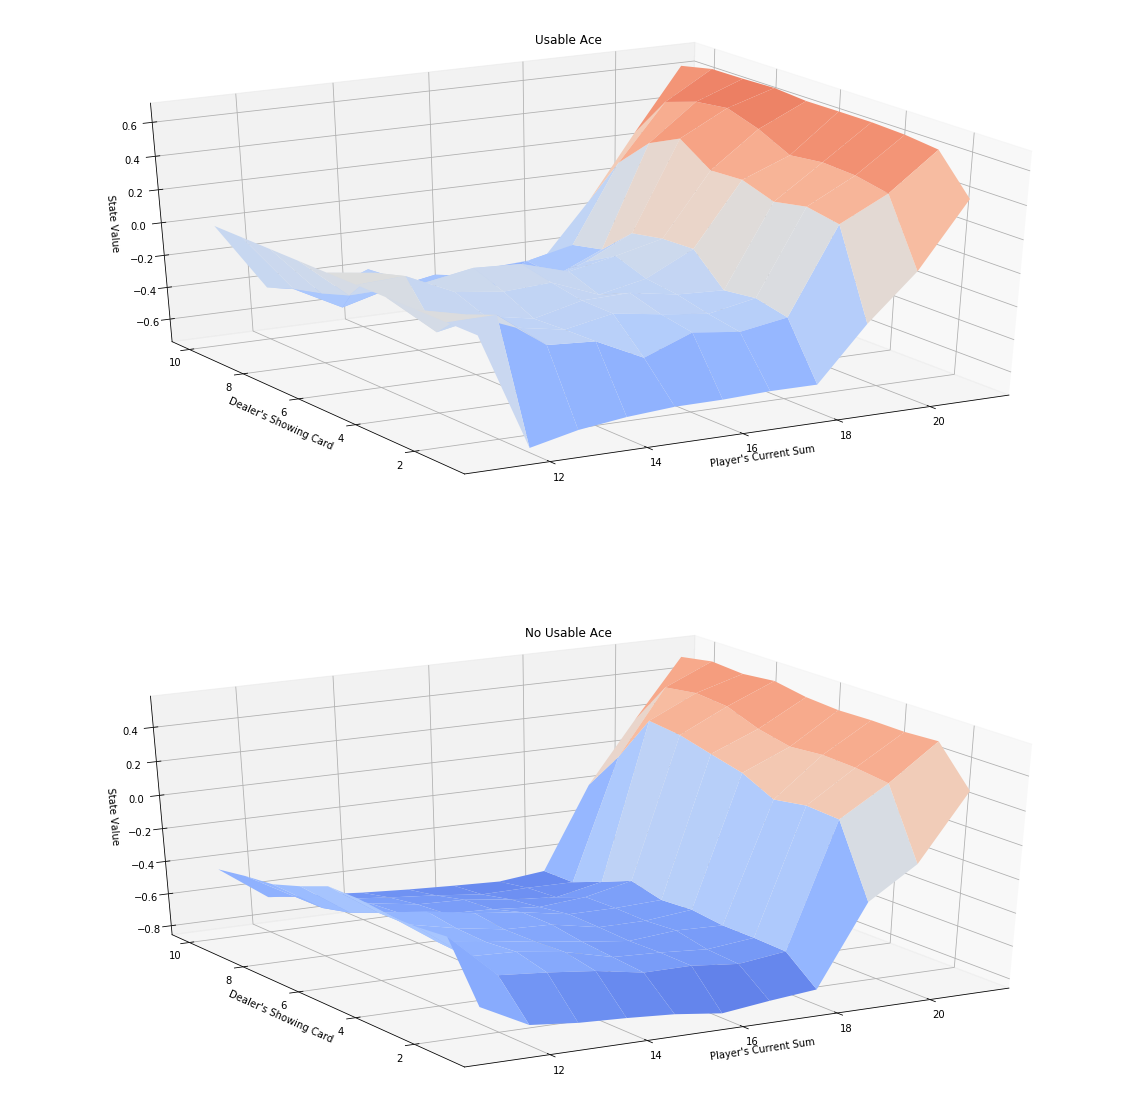

In [7]:
# obtain the action-value function
Q = first_visit_q(env, 500000, generate_episode)

# obtain the corresponding state-value function
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V_to_plot)

What happens if we repeat the same process, but we set $\pi^\prime$ as the initial policy? $\pi \leftarrow \pi^\prime$
- What if we repeated the cycle again and again? Would we converge on $\pi^*$?

When we construct a policy where $\mathcal{a_i} = argmax_{a^\prime\in\mathcal{A}(s)}\mathcal{Q}(s,a^\prime)$ from a Q-table, we say that the policy is **greedy with respect to the Q-table.**

$$\pi^\prime \leftarrow greedy(\mathcal{Q})$$  

This greedy policy creates a bias towards known rewards. It does not promote exploration of the entire state-action-reward space. To combat this tradeoff between known rewards and exploration, we can create an **Epsilon-Greedy Policy.** The tradeoff is called the **Exploration-Exploitation Dilemma.**

Where as greedy policy _always_ selects the greedy action, an $\epsilon$-greedy policy has a non-zero probability to select the non-greedy (i.e., exploratory) action. 

If $\epsilon > 0$, there is a chance that the non-greedy action will be selected.  
If $\epsilon = 1$, this is the eqiprobable random policy. 

**The Control Problem**
> Estimate the optimal policy.

The $\epsilon$-greedy algorithm is a solution to the control problem, so we call it a **Monte Carlo control method.**

We want to change the value of $\epsilon$ over time as the agent becomes more experienced and has thoroughly explored the state-action-reward space.  

In order to guarantee that MC control converges to the optimal policy $\pi_*$ we need to ensure that two conditions are met. We refer to these conditions as **Greedy in the Limit with Infinite Exploration (GLIE)**. In particular, if:
 - every state-action pair is visited infinitely many times
 - the policy converges to a policy that is greedy with respect to the action-value function estiate $Q$  
 
One way to accomplish this would be $lim_{i\rightarrow\infty}\epsilon_i = 0$, since $\pi_*$ will have zero exploration. There are numerous ways to do this, an example is $\epsilon_i = \frac{1}{i}$

Practially speaking, GLIE isn't good enough because we don't know how close to infinity we need to approach. Often times you can get better results (than letting $\epsilon$ decay to 0) by either using a fixed $\epsilon$ or letting $\epsilon$ decay to a small positive number, like 0.1. This is because it's hard to pin down the decay rate.  

By introducing $\epsilon$, we can update $\pi^\prime$ after every episode rather than waiting for convergence. Let N = episode number, G = return, Q = estimated action value.  
$$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \frac{1}{N(S_t, A_t)}(G_t - Q(S_t, A_t)$$  
  
Where $\delta_t = G_t - Q(S_t, A_t)$. Because $Q(S_t, A_t)$ adjusted the average $\delta_t$, later episodes will not be able to impact the average even if their $\delta_t$ is significant. We can change the algorithm to introduce a constant $\alpha$ to normalize the impact of all $\delta_t$.  
$$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha(G_t - Q(S_t, A_t)$$

**How to set the value of $\alpha$**  

First, rewrite the equation as:
$$Q(S_t, A_t) \leftarrow (1 - \alpha) \cdot Q(S_t, A_t) + \alpha \cdot G_t$$

Setting $\alpha = 1$ would completely ignore the estimated action-value and replace it with the most recent reward. Setting $\alpha = 0$ would completely ignore the newest reward and keep the existing action-value estimate. 

This is basically the learning rate in SGD. 

In [8]:
def generate_episode_from_Q(env, Q, epsilon, nA):
    """ generates an episode from following the epsilon-greedy policy """
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

def update_Q(env, episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

In [9]:
def mc_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_start
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # set the value of epsilon
        epsilon = max(epsilon*eps_decay, eps_min)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q = update_Q(env, episode, Q, alpha, gamma)
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    return policy, Q

In [10]:
# obtain the estimated optimal policy and action-value function
policy, Q = mc_control(env, 500000, 0.02)

Episode 500000/500000.

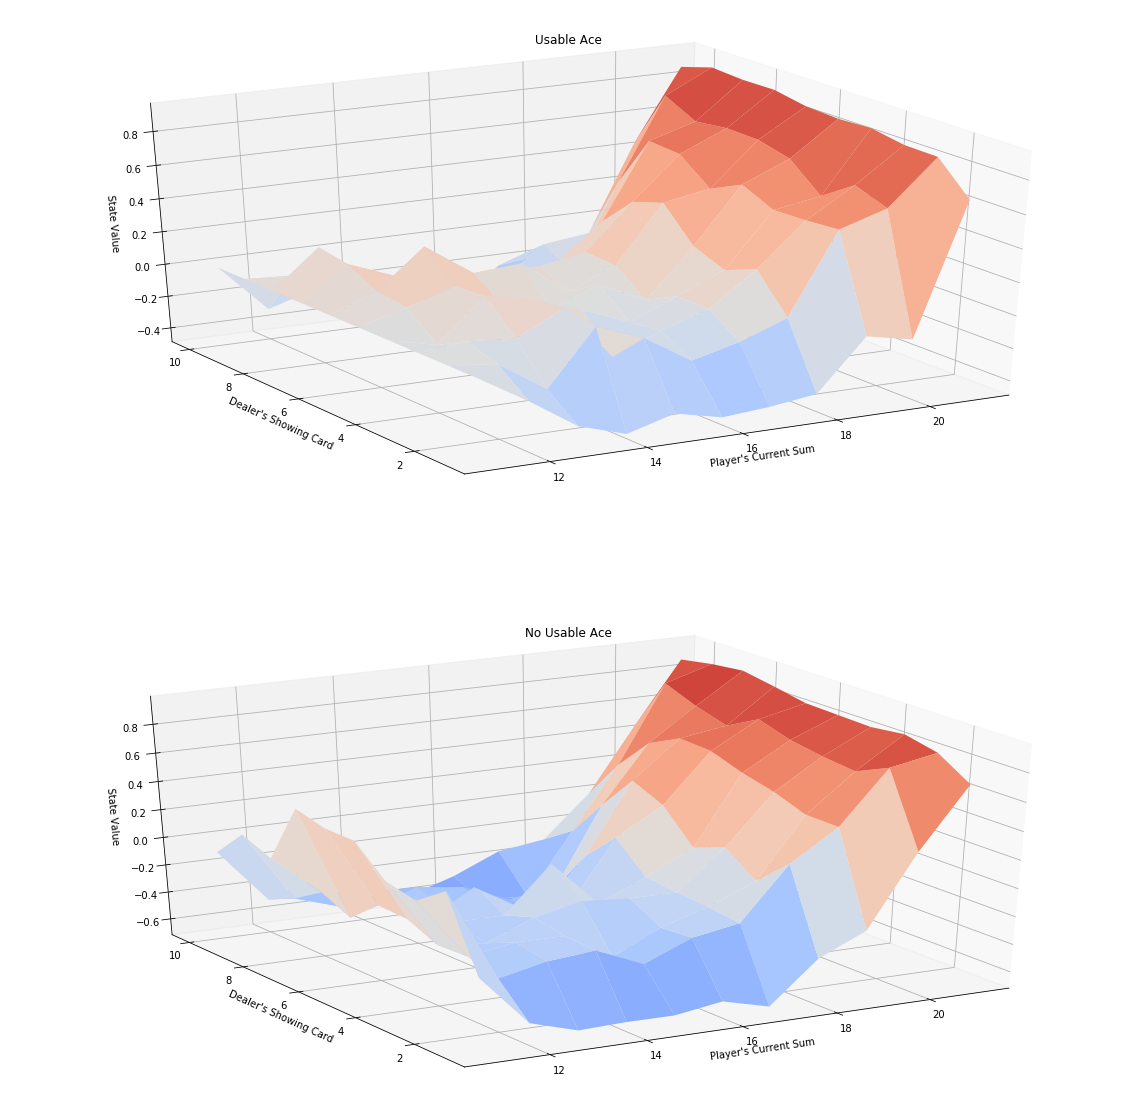

In [11]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

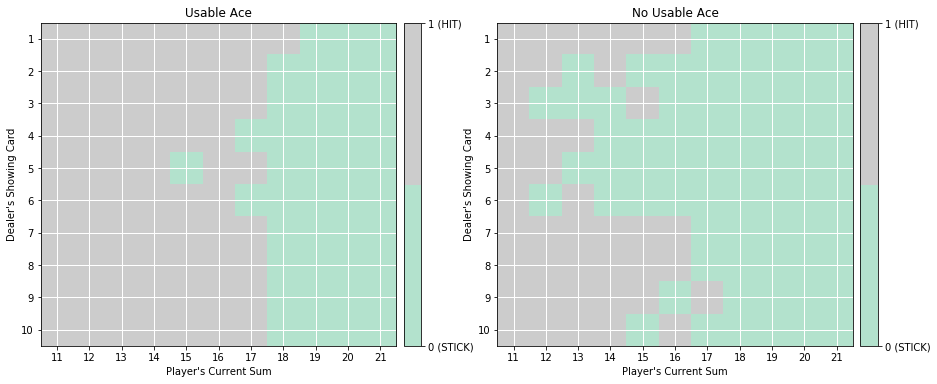

In [12]:
# plot the policy
plot_policy(policy)